In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.metrics
from sklearn.model_selection import train_test_split
import math
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


%load_ext autoreload
%autoreload 2
from NNFunctions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [265]:
x_train = pd.read_csv('./Data with correct player_atts/x_train.csv')
x_val = pd.read_csv('./Data with correct player_atts/x_val.csv')
x_test = pd.read_csv('./Data with correct player_atts/x_test.csv')

y_train = pd.read_csv('./Data with correct player_atts/y_train.csv')
y_val = pd.read_csv('./Data with correct player_atts/y_val.csv')
y_test = pd.read_csv('./Data with correct player_atts/y_test.csv')

x_train.shape, x_val.shape, x_test.shape

((8768, 47), (825, 47), (833, 47))

In [273]:
print('B365 Binary log_loss: {}'.format(log_loss(y_train.target_binary, x_train[[ 'B365H', 'B365NH']])))

B365 Binary log_loss: 0.6216678337039018


## Initialise Models

In [6]:

input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 3

model_dict = {

'model4': LinearNN(5, (input_size,output_size), [128,256,128,32,16], nn.ReLU(), 0.5),
'model5': LinearNN(5, (input_size,output_size), [128,512,256,128,32], nn.ReLU(), 0.5),
'model6': LinearNN(5, (input_size,output_size), [64,512,256,128,32], nn.ReLU(), 0),
'model7': LinearNN(6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0.5),
'model8': LinearNN(6, (input_size,output_size), [64,256,256,128,64,32], nn.ReLU(), 0),
'model9': LinearNN(6, (input_size,output_size), [256,512,512,128,32,16], nn.ReLU(), 0.5),
'model10': LinearNN(7, (input_size,output_size), [64,256,256,128,32,16,8], nn.ReLU(), 0.5),
'model11': LinearNN(7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0),
'model12': LinearNN(7, (input_size,output_size), [256,512,128,64,32,16,8], nn.ReLU(), 0.5),
'model13': LinearNN(8, (input_size,output_size), [64,128,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(8, (input_size,output_size), [128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(8, (input_size,output_size), [256,512,512,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(9, (input_size,output_size), [64,128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(9, (input_size,output_size), [128,256,256,128,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(9, (input_size,output_size), [256,512,512,256,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(10, (input_size,output_size), [64,128,256,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(10, (input_size,output_size), [128,256,256,512,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(10, (input_size,output_size), [256,512,512,256,256,128,32,16,8,8], nn.ReLU(), 0.5),
}

In [6]:

input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 3

model_dict = {

'model4': LinearNN(5, (input_size,output_size), [128,256,128,32,16], nn.ReLU(), 0.5),
'model5': LinearNN(5, (input_size,output_size), [128,512,256,128,32], nn.ReLU(), 0.5),
'model6': LinearNN(5, (input_size,output_size), [64,512,256,128,32], nn.ReLU(), 0),
'model7': LinearNN(6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0.5),
'model8': LinearNN(6, (input_size,output_size), [64,256,256,128,64,32], nn.ReLU(), 0),
'model9': LinearNN(6, (input_size,output_size), [256,512,512,128,32,16], nn.ReLU(), 0.5),
'model10': LinearNN(7, (input_size,output_size), [64,256,256,128,32,16,8], nn.ReLU(), 0.5),
'model11': LinearNN(7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0),
'model12': LinearNN(7, (input_size,output_size), [256,512,128,64,32,16,8], nn.ReLU(), 0.5),
'model13': LinearNN(8, (input_size,output_size), [64,128,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(8, (input_size,output_size), [128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(8, (input_size,output_size), [256,512,512,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(9, (input_size,output_size), [64,128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(9, (input_size,output_size), [128,256,256,128,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(9, (input_size,output_size), [256,512,512,256,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(10, (input_size,output_size), [64,128,256,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(10, (input_size,output_size), [128,256,256,512,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(10, (input_size,output_size), [256,512,512,256,256,128,32,16,8,8], nn.ReLU(), 0.5),
}

## Train Models

In [275]:

input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 2

model_dict = {

#'model4': LinearNN(5, (input_size,output_size), [128,256,128,32,16], nn.ReLU(), 0.2),
'model7': LinearNN(6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0.5),
'model10': LinearNN(7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0.4),
'model17': LinearNN(6, (input_size,output_size), [256,512,256,128,32,16], nn.ReLU(), 0.5),
#'model20': LinearNN(7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0.5),
# 'model11': LinearNN(7, (input_size,output_size), [128,256,512,256,64,16,8], nn.ReLU(), 0.2),
# 'model12': LinearNN(8, (input_size,output_size), [256,512,512,256,128,64,16,8], nn.ReLU(), 0.2),
#'model13': LinearNN(9, (input_size,output_size), [128,128,256,256,128,64,32,16,8], nn.ReLU(), 0.2),
#'model14': LinearNN(10, (input_size,output_size), [64,128,256,256,256,128,64,32,16,8], nn.ReLU(), 0.5),

}

In [161]:
model_dict['model7'] = LinearNN(6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0.2)

In [ ]:
splits = 1
results, big_losses_list = train_many(model_dict, x_train, y_train, batch_size = len(X_train) , splits = splits, epochs = 10, learning_rate = 0.004)
results


model7
.  
model10
.  
model17


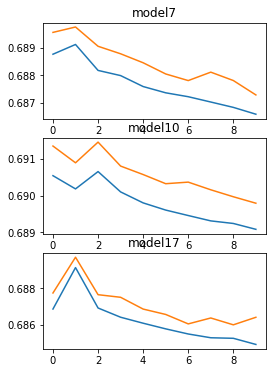

In [303]:
plot_losses(big_losses_list, model_dict, splits)

In [324]:
pred = get_score(model_dict['model7'].model, x_test, y_test, scaler)

0.56062424969988 0.6822965676758755


In [194]:
valscaler = preprocessing.StandardScaler().fit(x_val.iloc[:,1:])
get_score(model_dict['model20'].model, x_val, y_val, valscaler)

(0.4703748488512696, 1.1003493316732842)

In [193]:
get_score(model_dict['model20'].model, x_val, y_val, scaler)

(0.46311970979443773, 1.1009453383906145)

In [315]:
## Ensemble learning
scaler = preprocessing.StandardScaler().fit(x_train.iloc[:,1:])
x_ens = get_ens_df(x_train, scaler, model_dict)
x_ens_val = get_ens_df(x_val, scaler, model_dict)

RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
RF_clf.fit(x_ens, y_train['target_binary'])


RandomForestClassifier(max_depth=2, random_state=0)

In [316]:
print('Train Accuracy: {}'.format(RF_clf.score(x_ens, y_train['target_binary'])))
print('Val Accuracy: {}'.format(RF_clf.score(x_ens_val, y_val['target_binary'])))
print('Train log loss: {}'.format(log_loss(y_train['target_binary'], RF_clf.predict_proba(x_ens))))
print('Val log loss: {}'.format(log_loss(y_val['target_binary'], RF_clf.predict_proba(x_ens_val))))

Train Accuracy: 0.6537408759124088
Val Accuracy: 0.6557575757575758
Train log loss: 0.6194620207662623
Val log loss: 0.6167921491369757


In [220]:
ensemble_predict_simple([model_dict['model20'].model, model_dict['model7'].model, model_dict['model10'].model], x_val, y_val, scaler)

Ensemble accuracy: 0.501813784764208
